An attempt to infer hidden states of a switching linear dynamical system
Linear dynamics is given by an ODE
$$
\dot{x} = -\alpha(s) x,
$$
where $x\in\mathbb{R}^1$ and $\alpha$ is controlled by a discrete latent variable $s$. 

For simplicity, ODE is discretised simply as
$$
x_{t+1} = x_t - \Delta t\cdot\alpha(s)\cdot x_t = \big(1 - \Delta t\cdot\alpha(s)\big)\cdot x_t.
$$

In [1]:
import Pkg
Pkg.activate("../")

  Activating environment at `~/code/LearningBayes.jl/Project.toml`


In [2]:
using Plots
using Rocket
using GraphPPL
using ReactiveMP
using Distributions
using LinearAlgebra
using Random

In [3]:
function decay(t, α, x0)
    """ Simulate decay with a constant rate α """
    return @. x0 * exp(-α * (t - t[1]))
end

decay (generic function with 1 method)

In [4]:
n = 100
dt = 1 / n
t = collect(0:dt:1-dt)
x0 = 50.
# introduce two decay rates
α0 = 2.
α1 = 10.
σy = 2; # observation noise

In [5]:
# Generate the data for two different regimes
xs0 = decay(t[1:Int(.5*n)], α0, x0);
xs1 = decay(t[Int(.5*n)+1:end], α1, xs0[end]);
x = vcat(xs0, xs1);

y = x .+ randn(n) * σy;

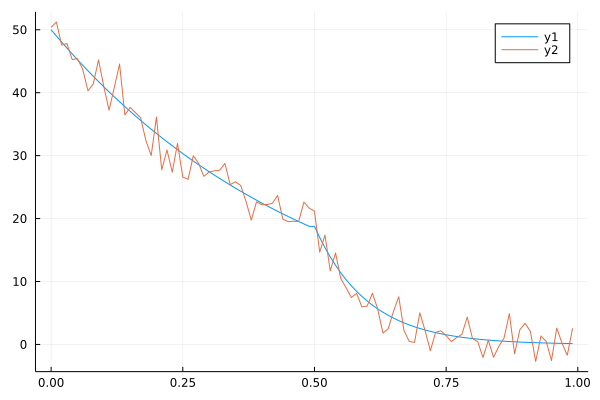

In [6]:
plot(t, x)
plot!(t, y)

# No switching at first, filter a homogeneous timeperiod as a test

In [7]:
@model function model_without_state(n, μ0, Tx::ConstVariable, σx::ConstVariable, σy::ConstVariable)
    
    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prior ~ NormalMeanVariance(μ0, σx)
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ NormalMeanVariance(Tx * x_prev, σx)
        y[i] ~ NormalMeanVariance(x[i], σy)
        
        x_prev = x[i]
    end
    
    return x, y
end

model_without_state (generic function with 1 method)

In [8]:
function inference(observations, model_func, model_args...)
    n = length(observations)

    model, (x, y) = model_func(n, model_args...)
    buffer = keep(Vector{Marginal})
    subscription = subscribe!(getmarginals(x), buffer)
    update!(y, observations)
    unsubscribe!(subscription)
    
    return buffer
end

inference (generic function with 1 method)

In [9]:
σx = 0.1
Tx = 1 - α1 * dt
xmarginals = inference(y[50:end], model_without_state, 20, Tx, σx, σy);

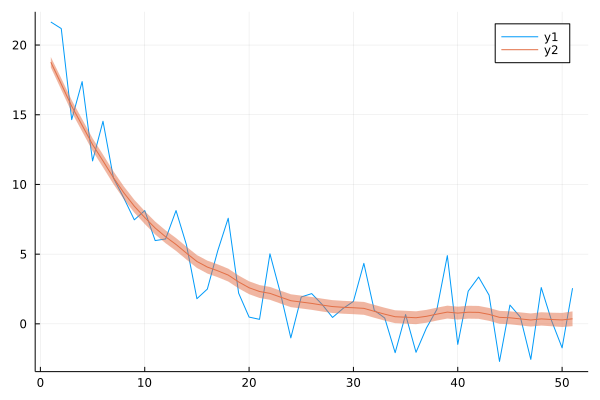

In [10]:
plot(y[50:end])
plot!(mean.(xmarginals[end]), ribbon = var.(xmarginals[end]) .|> sqrt)

# Add switching dynamic via a categorical latent variable

In [11]:
@model function model_via_transition(n, μ0, σx::ConstVariable, σy::ConstVariable)
    
    s = randomvar(n) # discrete state variable
    x = randomvar(n) # continuous latent variable
    y = datavar(Float64, n)
    
    s_prior ~ Categorical(fill(1.0 / 2.0, 2))
    x_prior ~ NormalMeanVariance(μ0, σx)
    Ts ~ MatrixDirichlet([8. 2.; 2. 8.]) # arbitrary (and ideally learnable) transition matrix for the discrete state
    Tα ~ MatrixDirichlet([α0 0; 0 α1]) # auxilary "transition matrix" for switching decay rate parameter
    
    s_prev = s_prior
    x_prev = x_prior
    for t in 1:n
        s[t] ~ Transition(s_prev, Ts) where { q = q(out, in)q(a) }
        α ~ Transition(s[t], Tα)
        Tx ~ 1 + (-dt) * α # avoiding ``Unknown functional form '-' used for node specification.``
        x[t] ~ NormalMeanVariance(Tx * x_prev, σx) 
        y[t] ~ NormalMeanVariance(x[t], σy)
        
        s_prev = s[t]
        x_prev = x[t]
    end
    
    return s, x, y
end

model_via_transition (generic function with 1 method)

In [12]:
function inference(model_func, observations, μ0, σx, σy)
    n = length(observations)

    model, (s, x, y) = model_func(n, μ0, σx, σy);
    buffer_s = keep(Vector{Marginal})
    buffer_x = keep(Vector{Marginal})
    subs_s = subscribe!(getmarginals(s), buffer_s)
    subs_x = subscribe!(getmarginals(x), buffer_x)
    update!(y, observations)
    unsubscribe!(subs_s)
    unsubscribe!(subs_x)
    
    return buffer_s, buffer_x
end

inference (generic function with 2 methods)

In [13]:
marginals_s, marginals_x = inference(model_via_transition, y[1:20], x0, σx, σy);

In [14]:
marginals_s

KeepActor{Vector{Marginal}}(Vector{Marginal}[])

Clueless what I am missing here